# Demo notebook for generating simple plots from Bonsai/Harp nwb files

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO

nwb_folder = '/root/capsule/data/foraging_nwb_bonsai'

Some util funcs

In [2]:
def moving_average(a, n=3) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    
def plot_session_lightweight(data,   # choice_history, reward_history, p_reward
                             fitted_data=None, 
                             photostim=None,    # trial, power, s_type
                             valid_range=None,
                             smooth_factor=5, 
                             base_color='y', 
                             ax=None, 
                             vertical=False):
    # sns.reset_orig()
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 3) if not vertical else (3, 12), dpi=200)
        plt.subplots_adjust(left=0.1, right=0.8, bottom=0.05, top=0.8)

    if not vertical:
        gs = ax._subplotspec.subgridspec(2, 1, height_ratios=[1, 0.2], hspace=0.1)
        ax_1 = ax.get_figure().add_subplot(gs[0, 0])
        ax_2 = ax.get_figure().add_subplot(gs[1, 0])
        ax_1.get_shared_x_axes().join(ax_1, ax_2)
    else:
        gs = ax._subplotspec.subgridspec(1, 2, width_ratios=[0.2, 1], wspace=0.1)
        ax_1 = ax.get_figure().add_subplot(gs[0, 1])
        ax_2 = ax.get_figure().add_subplot(gs[0, 0])
        ax_1.get_shared_y_axes().join(ax_1, ax_2)
        
    with sns.plotting_context("notebook", font_scale=1):

        choice_history, reward_history, p_reward = data

        # == Fetch data ==
        n_trials = np.shape(choice_history)[1]

        p_reward_fraction = p_reward[1, :] / (np.sum(p_reward, axis=0))

        ignored_trials = np.isnan(choice_history[0])
        rewarded_trials = np.any(reward_history, axis=0)
        unrewarded_trials = np.logical_not(np.logical_or(rewarded_trials, ignored_trials))

        # == Choice trace ==
        # Rewarded trials
        xx = np.nonzero(rewarded_trials)[0] + 1
        yy = 0.5 + (choice_history[0, rewarded_trials] - 0.5) * 1.4
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)], 
                '|' if not vertical else '_', color='black', markersize=10, markeredgewidth=2)

        # Unrewarded trials
        xx = np.nonzero(unrewarded_trials)[0] + 1
        yy = 0.5 + (choice_history[0, unrewarded_trials] - 0.5) * 1.4
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                '|' if not vertical else '_', color='gray', markersize=6, markeredgewidth=1)

        # Ignored trials
        xx = np.nonzero(ignored_trials)[0] + 1
        yy = [1.1] * sum(ignored_trials)
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                'x', color='red', markersize=2, markeredgewidth=0.5, label='ignored')

        # Base probability
        xx = np.arange(0, n_trials) + 1
        yy = p_reward_fraction
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                color=base_color, label='base rew. prob.', lw=1.5)

        # Smoothed choice history
        y = moving_average(choice_history, smooth_factor) / moving_average(~np.isnan(choice_history), smooth_factor)
        x = np.arange(0, len(y)) + int(smooth_factor / 2) + 1
        ax_1.plot(*(x, y) if not vertical else [*(y, x)],
                linewidth=1.5, color='black', label='choice (smooth = %g)' % smooth_factor)
        
        # finished ratio
        if np.sum(np.isnan(choice_history)):
            x = np.arange(0, len(y)) + int(smooth_factor / 2) + 1
            y = moving_average(~np.isnan(choice_history), smooth_factor)
            ax_1.plot(*(x, y) if not vertical else [*(y, x)],
                    linewidth=0.8, color='m', alpha=1,
                    label='finished (smooth = %g)' % smooth_factor)
             
        # add valid ranage
        if valid_range is not None:
            add_range = ax_1.axhline if vertical else ax_1.axvline
            add_range(valid_range[0], color='m', ls='--', lw=1, label='motivation good')
            add_range(valid_range[1], color='m', ls='--', lw=1)
                
        # For each session, if any fitted_data
        if fitted_data is not None:
            ax_1.plot(np.arange(0, n_trials), fitted_data[1, :], linewidth=1.5, label='model')
        
        # == photo stim ==
        if photostim is not None:
            plot_spec_photostim = { 'after iti start': 'cyan',  
                                    'before go cue': 'cyan',
                                    'after go cue': 'green',
                                    'whole trial': 'blue'}
            
            trial, power, s_type = photostim
            x = trial
            y = np.ones_like(trial) + 0.4
            scatter = ax_1.scatter(
                                *(x, y) if not vertical else [*(y, x)],
                                s=power.astype(float)*2,
                                edgecolors=[plot_spec_photostim[t] for t in s_type]
                                  if any(s_type) else 'darkcyan',
                                marker='v' if not vertical else '<',
                                facecolors='none',
                                linewidth=0.5,
                                label='photostim')

        # p_reward    
        xx = np.arange(0, n_trials) + 1
        ll = p_reward[0, :]
        rr = p_reward[1, :]
        ax_2.plot(*(xx, rr) if not vertical else [*(rr, xx)],
                color='b', label='p_right', lw=1)
        ax_2.plot(*(xx, ll) if not vertical else [*(ll, xx)],
                color='r', label='p_left', lw=1)
        ax_2.legend(fontsize=5, ncol=1, loc='upper left', bbox_to_anchor=(0, 1))
        
        if not vertical:
            ax_1.set_yticks([0, 1])
            ax_1.set_yticklabels(['Left', 'Right'])
            ax_1.legend(fontsize=6, loc='upper left', bbox_to_anchor=(0.6, 1.3), ncol=2)
            ax_1.set_xticks([])

            sns.despine(trim=True, bottom=True, ax=ax_1)
            sns.despine(trim=True, ax=ax_2)
        else:
            ax_1.set_xticks([0, 1])
            ax_1.set_xticklabels(['Left', 'Right'])
            ax_1.invert_yaxis()
            ax_1.legend(fontsize=6, loc='upper left', bbox_to_anchor=(0, 1.05), ncol=2)
            ax_1.set_yticks([])

            sns.despine(trim=True, left=True, ax=ax_1)
            sns.despine(trim=True, ax=ax_2)


        # ax_2.set(ylim=(0, 1))
    
    # ax.set_xlim(0,300)

    # fig.tight_layout()
    ax_2.set(xlabel='Trial number')
    ax.remove()

    return ax_1.get_figure(), [ax_1, ax_2]

## Load one session

In [3]:
nwb_file = '668551_2023-06-15_3.nwb'

io = NWBHDF5IO(nwb_folder + '/' + nwb_file, mode='r')
nwb = io.read()

In [4]:
nwb

root pynwb.file.NWBFile at 0x140018021372064
Fields:
  acquisition: {
    left_lick_time <class 'pynwb.base.TimeSeries'>,
    left_reward_delivery_time <class 'pynwb.base.TimeSeries'>,
    right_lick_time <class 'pynwb.base.TimeSeries'>,
    right_reward_delivery_time <class 'pynwb.base.TimeSeries'>
  }
  experiment_description: Optogenetics target brain areas:
  experimenter: ['Lucas']
  file_create_date: [datetime.datetime(2023, 7, 18, 17, 56, 28, 142426, tzinfo=tzoffset(None, -25200))]
  identifier: bc3846af-e603-49b2-9276-c80706f438b7
  institution: Allen Institute for Neural Dynamics
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  protocol: Coupled Without Baiting
  related_publications: ['']
  session_description: Session end time:2023-06-15 15:21:43.186666  Give extra water(ml):  Training tower:Tower-5
  session_id: 668551_2023-06-15_3.json
  session_start_time: 2023-06-15 14:31:02.214445-07:00
  subject: subject pynwb.file.Subject at 0x140018020836640
Fields:
  description: Animal name:668551  Weight after(g):
  species: Mus musculus
  subject_id: 668551
  weight: 22.3

  timestamps_reference_time: 2023-06-15 14:31:02.214445-07:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'>

## Behavioral trials

In [5]:
df_trials = nwb.trials.to_dataframe()
df_trials['trial'] = df_trials.index + 1 # Add an one-based trial number column
df_trials

,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,...,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,trial
id,,,,,,,,,,,,,,,,,,,,,
0,97536.889504,97543.067488,1.0,False,True,97538.183488,97539.702496,97540.054976,False,True,...,0,0,0,0,0,0,0,0,0,1
1,97543.074496,97549.700480,2.0,False,False,97544.167488,97545.685504,97546.682976,True,False,...,0,0,0,0,0,0,0,0,0,2
2,97549.707488,97557.434496,2.0,False,False,97552.084480,97553.419488,97554.414976,True,False,...,0,0,0,0,0,0,0,0,0,3
3,97557.441504,97565.283488,2.0,False,False,97560.233504,97561.268480,97562.265984,True,False,...,0,0,0,0,0,0,0,0,0,4
4,97565.290496,97574.834496,2.0,False,False,97569.300480,97570.819488,97571.816000,True,False,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,100535.756480,100544.683488,0.0,True,False,100540.349504,100541.469504,100541.669984,True,False,...,0,0,0,0,0,0,0,0,0,270
270,100544.691488,100551.249504,0.0,True,False,100546.566496,100548.051488,100548.230976,True,False,...,0,0,0,0,0,0,0,0,0,271
271,100551.256480,100557.999488,0.0,False,False,100553.016480,100554.767488,100554.984000,False,True,...,0,0,0,0,0,0,0,0,0,272


In [6]:
df_trials.columns

Index(['start_time', 'stop_time', 'animal_response', 'rewarded_historyL',
       'rewarded_historyR', 'delay_start_time', 'goCue_start_time',
       'reward_outcome_time', 'bait_left', 'bait_right',
       'base_reward_probability_sum', 'reward_probabilityL',
       'reward_probabilityR', 'left_valve_open_time', 'right_valve_open_time',
       'block_beta', 'block_min', 'block_max', 'min_reward_each_block',
       'delay_beta', 'delay_min', 'delay_max', 'delay_duration', 'ITI_beta',
       'ITI_min', 'ITI_max', 'ITI_duration', 'response_duration',
       'reward_consumption_duration', 'auto_waterL', 'auto_waterR',
       'laser_on_trial', 'laser_wavelength', 'laser_location', 'laser_power',
       'laser_duration', 'laser_condition', 'laser_condition_probability',
       'laser_start', 'laser_start_offset', 'laser_end', 'laser_end_offset',
       'laser_protocol', 'laser_frequency', 'laser_rampingdown',
       'laser_pulse_duration', 'trial'],
      dtype='object')

In [7]:
nwb.trials.animal_response.description

'The response of the animal. 0, left choice; 1, right choice; 2, no response'

### Trial view

In [8]:
df_trials.rewarded_historyL

id
0      False
1      False
2      False
3      False
4      False
       ...  
269     True
270     True
271    False
272    False
273    False
Name: rewarded_historyL, Length: 274, dtype: bool

/tmp/ipykernel_507/3959381533.py:24: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax_1.get_shared_x_axes().join(ax_1, ax_2)
/tmp/ipykernel_507/3959381533.py:70: RuntimeWarning: invalid value encountered in divide
  y = moving_average(choice_history, smooth_factor) / moving_average(~np.isnan(choice_history), smooth_factor)


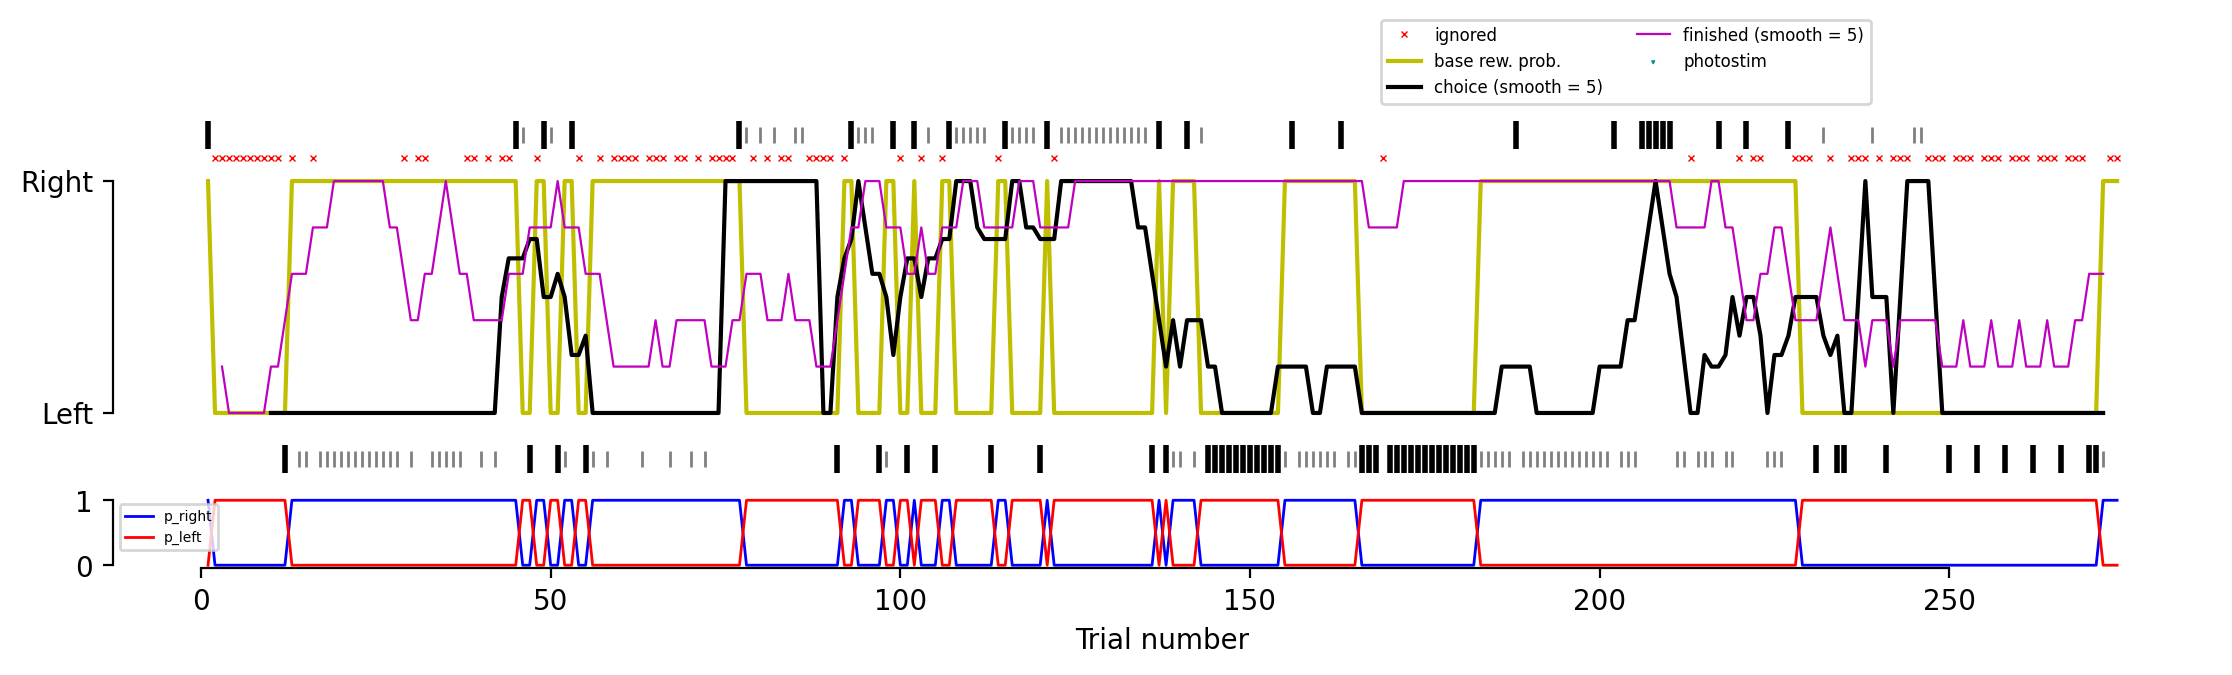

In [9]:
# Reformat data
choice_history = df_trials.animal_response.map({0: 0, 1: 1, 2: np.nan}).values
reward_history = np.vstack([df_trials.rewarded_historyL, df_trials.rewarded_historyR])
p_reward = np.vstack([df_trials.reward_probabilityL, df_trials.reward_probabilityR])

# photostim
photostim_trials = df_trials.laser_power > 0
photostim = [df_trials.trial[photostim_trials], df_trials.laser_power[photostim_trials], []]

# Plot session
fig, ax = plot_session_lightweight([np.array([choice_history]), reward_history, p_reward], photostim=photostim)

In [10]:
from plot.foraging_plotly import plot_session_lightweight as plot_session_lightweight_plotly

SyntaxError: invalid syntax (foraging_plotly.py, line 20)

In [ ]:
plot_session_lightweight_plotly(choice_history, reward_history, p_reward, smooth_factor=5, 
                                bait_history=np.vstack([df_trials.bait_left, df_trials.bait_right]))µ

/root/capsule/code/plot/foraging_plotly.py:51: RuntimeWarning:

invalid value encountered in divide



## Behavioral events

#### Here is the trial structure

1. In the inter-trial-interval (ITI), lickports are far from the mice.
2. (Some sessions) at the trial start, lickports move forward to the "ready" position (`lickportready`, ephys only)
3. A "no-lick period" starts (relatively short in my experiments, ~0.2-0.5 sec)
4. In the "no-lick period", if there is a "early lick", add a 2 sec timeout, and go back to `3` (still in the same trial)
5. If there is no early lick, deliver a `go_cue` sound, and a "response window" starts (typically 5 sec)
6. If there is any lick in the response window:
    <br>i. The first lick after the go cue is considered as `choice`. Deliver reward if a reward exists on the chosen lickport ("hit"), otherwise, "miss"
   <br>ii. If there is no more lick in any 1-second window, go to `8`. (In other words, if the mouse keeps licking, the trial will become very long)
   <br>iii. If there is any lick to the other lickport than the "choice", this trial is "double-dipped". In part of experiments, the trial will be terminated (go to `8`) to discourage double-dipping.
7. If there is no lick in the response window, this trial is an "ignore" trial, and go to `8`.
8. `trialend`: lickports are retracted and IT starts.## Behavioral trials

Time stamps stored in `df_trial`

In [ ]:
[t for t in df_trials.columns if 'time' in t.lower()]

['start_time',
 'stop_time',
 'delay_start_time',
 'goCue_start_time',
 'reward_outcome_time',
 'left_valve_open_time',
 'right_valve_open_time']

Get the session start time

In [ ]:
t0 = df_trials.start_time[0]

Note that the "RewardOutcomeTime" is not accurate in `df_trial`. We should use the one in `nwb.acquisition`.

In [ ]:
nwb.acquisition.keys()

dict_keys(['left_lick_time', 'left_reward_delivery_time', 'right_lick_time', 'right_reward_delivery_time'])

Get all times (all times are relative to the first trial start of a session, in sec)

In [ ]:
key_from_df = ['start_time', 'stop_time', 'delay_start_time', 'goCue_start_time', 'reward_outcome_time']
t_from_df = {key: df_trials[key] - t0 for key in key_from_df}

key_from_acq = ['left_lick_time', 'right_lick_time', 'left_reward_delivery_time', 'right_reward_delivery_time']
t_from_acq = {key: nwb.acquisition[key].timestamps[:] - t0 for key in key_from_acq}

## Time view

In [ ]:
event_color_map = { 'trial_start': 'black',
                    'delay_start': 'gray',
                    'go': 'green',
                 #    'choice': 'm', 
                   'left_lick': 'red',
                   'right_lick': 'blue',                 
                   'reward (from df_trials)': 'cyan', 
                   'left_reward (from acq)': 'red',
                   'right_reward (from acq)': 'blue',
                   'trialend': 'black'}

event_times = [t_from_df['start_time'], 
               t_from_df['delay_start_time'],
               t_from_df['goCue_start_time'],
               t_from_acq['left_lick_time'], 
               t_from_acq['right_lick_time'], 
               t_from_df['reward_outcome_time'][np.any(reward_history, axis=0)],
               t_from_acq['left_reward_delivery_time'],
               t_from_acq['right_reward_delivery_time'],
               t_from_df['stop_time'],
               ]
               

# fig, ax = plt.subplots(1, 1, figsize=(20, 3))
# ax.eventplot(event_times, colors=list(event_color_map.values()), linelengths=0.6, lineoffsets=-1)
# ax.legend(event_color_map)
# ax.set_xlim((0, 20))
# ax.set(xlabel='Time (sec)')

In [ ]:
nwb.acquisition['left_lick_time']

left_lick_time pynwb.base.TimeSeries at 0x139848049382400
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (1435,), type "<f8">
  description: The time of left licks
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (1435,), type "<f8">
  timestamps_unit: seconds
  unit: second

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

for n, event in enumerate(event_color_map.keys()):
    fig.add_trace(go.Scatter(
                            x=event_times[n],
                            y=np.full_like(event_times[n], 10 - n),
                            mode='markers',
                            marker=dict(symbol='line-ns',
                                        size=15,
                                        line_width=2,
                                        line_color=event_color_map[event],
                                        ),
                            name=event,
                            ))

# Set layout
fig.update_layout(
    xaxis=dict(title='Time (sec)'),
    yaxis=dict(showticklabels=False)
)

# Show the plot
fig.show()

Time difference of reward delivery

In [ ]:
t_reward_from_acq = np.sort(np.hstack([t_from_acq['left_reward_delivery_time'], t_from_acq['right_reward_delivery_time']]))
t_diff = t_from_df['reward_outcome_time'][np.any(reward_history, axis=0)].values - t_reward_from_acq

ValueError: operands could not be broadcast together with shapes (253,) (260,) 

In [ ]:
t_reward_from_acq

array([ 116.901984,  184.742976,  234.564   ,  234.746976,  235.066976,
        254.824   ,  255.014976,  260.409984,  276.250976,  283.888992,
        357.814976,  412.428992,  511.502976,  519.644992,  528.093984,
        535.245984,  550.904992,  585.070976,  635.98    ,  651.348992,
        661.065984,  868.664992,  876.968   ,  893.198976,  922.186976,
        928.506976,  934.8     ,  949.496   ,  995.397984, 1002.061984,
       1009.665984, 1015.698976, 1059.492992, 1130.824   , 1137.076992,
       1166.32    , 1181.053984, 1195.506976, 1220.172992, 1231.708   ,
       1249.088   , 1293.273984, 1347.558976, 1373.268992, 1415.864   ,
       1457.545984, 1518.181984, 1580.332992, 1586.104992, 1714.332   ,
       1724.948   , 1732.342976, 1759.698976, 1780.92    , 1796.732   ,
       1807.477984, 1837.353984, 1883.984992, 2077.376992, 2102.090976,
       2111.484992, 2117.338976, 2123.428992, 2151.764992, 2355.225984,
       2368.524   , 2401.382976, 2424.849984, 2431.213984, 2439.

In [ ]:
t_diff

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
import plotly.express as px

fig = px.histogram(t_from_df['reward_outcome_time'][np.any(reward_history, axis=0)].values - t_reward_from_acq)
fig.show()

ValueError: operands could not be broadcast together with shapes (197,) (205,) 

## Issues to discuss:

1. Precision issue
2. Python nameing conventions

## All sessions

In [6]:
df_all_sessions = pd.read_pickle('/root/capsule/results/all_sessions.pkl')
df_all_sessions

type                               metadata                
variable                                rig experimenter   
subject_id session_date nwb_suffix                         
668463     2023-07-07   0           Tower-1        Lucas  \
                        1           Tower-1        Lucas   
           2023-07-10   0           Tower-1        Lucas   
           2023-07-11   0           Tower-1        Lucas   
           2023-07-13   0           Tower-1        Lucas   
           2023-07-14   0           Tower-1        Lucas   
           2023-07-17   0           Tower-1        Lucas   
           2023-07-18   0           Tower-1        Lucas   
           2023-07-19   0           Tower-1        Lucas   
           2023-07-20   0           Tower-1        Lucas   
           2023-07-21   0           Tower-1        Lucas   
           2023-07-25   0           Tower-1        Lucas   
668546     2023-06-14   0           Tower-5        Lucas   
668551     2023-06-13   0           Tower-5        Lucas   
           2023-06-15   0           Tower-5        Lucas   
                        1           Tower-5        Lucas   
                        2           Tower-5        Lucas   
                        3           Tower-5        Lucas   
           2023-06-16   0           Tower-5        Lucas   
                        1           Tower-5        Lucas   
671087     2023-07-06   0           Tower-1       Travis   
           2023-07-10   0           Tower-1       Travis   
           2023-07-11   0           Tower-1       Travis   
           2023-07-12   0           Tower-1       Travis   
           2023-07-13   0           Tower-1       Travis   
           2023-07-14   0           Tower-1       Travis   
           2023-07-17   0           Tower-1       Travis   
                        1           Tower-1       Travis   
           2023-07-18   0           Tower-1       Travis   
           2023-07-19   0           Tower-1       Travis   
           2023-07-20   0           Tower-1       Travis   
           2023-07-21   0           Tower-1       Travis   
           2023-07-24   0           Tower-1       Travis   
           2023-07-25   0           Tower-1       Travis   

type                                                                   
variable                                      experiment_description   
subject_id session_date nwb_suffix                                     
668463     2023-07-07   0           Optogenetics target brain areas:  \
                        1           Optogenetics target brain areas:   
           2023-07-10   0           Optogenetics target brain areas:   
           2023-07-11   0           Optogenetics target brain areas:   
           2023-07-13   0           Optogenetics target brain areas:   
           2023-07-14   0           Optogenetics target brain areas:   
           2023-07-17   0           Optogenetics target brain areas:   
           2023-07-18   0           Optogenetics target brain areas:   
           2023-07-19   0           Optogenetics target brain areas:   
           2023-07-20   0           Optogenetics target brain areas:   
           2023-07-21   0           Optogenetics target brain areas:   
           2023-07-25   0           Optogenetics target brain areas:   
668546     2023-06-14   0           Optogenetics target brain areas:   
668551     2023-06-13   0           Optogenetics target brain areas:   
           2023-06-15   0           Optogenetics target brain areas:   
                        1           Optogenetics target brain areas:   
                        2           Optogenetics target brain areas:   
                        3           Optogenetics target brain areas:   
           2023-06-16   0           Optogenetics target brain areas:   
                        1           Optogenetics target brain areas:   
671087     2023-07-06   0           Optogenetics target brain areas:   
           2023-07-10   0           Optogenetics ta